In [26]:
from os import sys
import os
sys.path.append('../')

%matplotlib widget

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aircraft import airplane
import propellers as prop

plt.style.use('../basic_plotter.mplstyle')

# Simple aerodynamic Model of Vehicle
CD0 = 0.018         # Zero lift drag coefficient
k   = 0.03          # Induced drag coefficient (1/(pi*AR*e))

# Static conditions
rho0 = 1.225        # Standard seal level air density for now
mass = 1.563 + 0.230 # Estimated with virtual bolt included
span = 2.54
chord = 0.149
linus = airplane(mass, chord, span)
linus_prop = prop.aeronaut11x7_estimatedBEN()

# Operating point variation
V_inf = np.linspace(8, 25.7, 30)      # Airspeed in meters per second to check operating point
throttle = np.linspace(0, 1, 20)       # Throttle as a floating fraction, for defining thrust as fraction of cruise thrust

# Meshing the inputs
V_INF_op, THROTTLE = np.meshgrid(V_inf, throttle)

# Calculating h dot from X and V
q = 0.5 * rho0 * V_INF_op**2
X_T_createv_cruise = (CD0 * q * linus.area) + (k * (q*linus.area)**-1 * linus.weight**2)
X_T_op = X_T_createv_cruise * THROTTLE
h_dot_op = (-X_T_createv_cruise * V_INF_op * linus.weight**-1) + (X_T_op * V_INF_op * linus.weight**-1)

0.0
35.01349508172537
0.04696228209652935
36.04845596350387
0.0939245641930587
37.02330587725881
0.14088684628958803
37.94910844123505
0.1878491283861174
38.83381955137225
0.23481141048264673
39.68339243233208
0.28177369257917606
40.50242324451601
0.3287359746757054
41.294551146680995
0.3756982567722348
42.062718161003716
0.4226605388687641
42.809344610457934
0.46962282096529345
43.536451433158796
0.5165851030618228
44.24574781844107
0.5635473851583521
44.938823234932975
0.6105096672548814
45.61664976003681
0.6574719493514108
46.28049952350937
0.7044342314479403
46.93133492718654
0.7513965135444696
47.57000728344155
0.7983587956409988
48.19727422474202
0.8453210777375282
48.813813749284044
0.8922833598340576
49.42023566249635
0.0
37.684777624397626
0.044688713489684256
38.60498227546393
0.08937742697936851
39.47986571949161
0.13406614046905277
40.3166434370484
0.17875485395873703
41.120751617990656
0.22344356744842128
41.89640938818827
0.26813228093810554
42.64697117695994
0.3128209944

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_37380/3593748611.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax1)


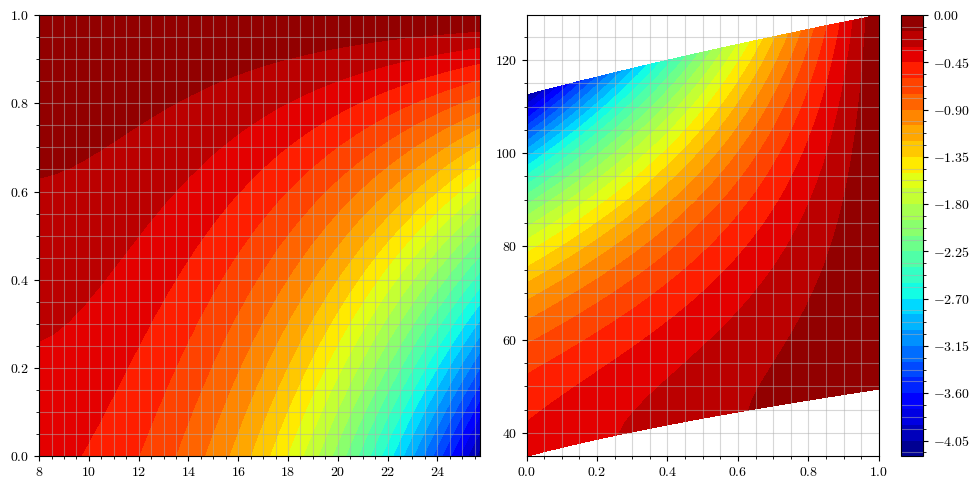

In [27]:
# Getting Estimates for propeller RPM
N_op = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        N_op[i, j] = linus_prop.getRPM(x_t_createv, rho0, v, n_guess=100)
        print(x_t_createv)
        print(N_op[i, j])

fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.contourf(V_INF_op, THROTTLE, h_dot_op, cmap="jet", levels=30)
pcm = ax1.contourf(THROTTLE, N_op, h_dot_op, cmap="jet", levels=30)
fig.colorbar(pcm, ax=ax1)
plt.show()

Only required inputs are:  
* N_op
* X_T_op
* V_INF_op

In [28]:
from sympy import init_printing
from sympy import *
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget
plt.style.use('../basic_plotter.mplstyle')
# Defining static conditions for cruise
[n_0, V_0, rho_0, C_D_0, X_T_0, h_dot_0]= symbols('n_0 V_0 \\rho_0 C_{D_0} X_{T_0} \dot{h}_0')
rho_0 = 1.225

# Defining complete input variables
[V_T, V,  U_dot, W_dot, h_dot, theta, n, rho, D, m, g, S, P, T] = symbols('V_T V \dot{U} \dot{W} \\dot{h} \\theta n \\rho D m g S P T')

# Defining outputs
[C_D, C_T, J, alpha] = symbols('C_D C_T J \\alpha')

dV = Symbol('\\Delta V')
dU_dot = Symbol('\\Delta \dot{U}')
dW_dot = Symbol('\\Delta \dot{W}')
dh_dot = Symbol('\\Delta \dot{h}')

dtheta = Symbol('\\Delta \\theta')
dn = Symbol('\\Delta n')
drho = Symbol('\\Delta \\rho')
dg = Symbol('\\Delta g')

## Defining the Operating Points at Cruise (For CREATeV)

Assumptions:
* No wind to speak of
* Perturbations happen one at a time, not all at once
* Cruising at conditions defined by some assumed drag polar
  * Drag Polar: $C_D = C_{D_0} + k C_L^2$
  * $C_{D_0} = 0.018$
  * $AR = \frac{b^2}{S} = 6.2V_op[i]^2 / (6.28 * 0.395) = 15.89$
  * $k = 1 / (\pi AR e) = 0.03$ (Assumption from range of polar results (0.029 to 0.0556))

In [29]:
# Defining Operating Points in Cruise (cruise_operatingpoints_working.ipynb)
# Based on 20x8 and CREATeV performance (cd0 = 0.018, k = 0.03)
area = linus.area
CL_alpha = np.array([12.02184177, -10.35785056])

## Complete Drag & Drag Equations

In [30]:
# Total Drag
C_D_total = (1/2 * rho * V_T**2 * S)**-1 * (-((U_dot+W_dot*alpha)*m) - (m * g * (-h_dot/V_T)) + X_T_0)
C_D_total

2.0*(X_{T_0} - m*(\alpha*\dot{W} + \dot{U}) + \dot{h}*g*m/V_T)/(S*V_T**2*\rho)

In [31]:
# Total Lift
C_L_total = (1/2 * rho * V_T**2 * S)**-1 * ( m* (U_dot*alpha - W_dot) + (m*g) - X_T_0*alpha )
C_L_total

2.0*(-X_{T_0}*\alpha + g*m + m*(\alpha*\dot{U} - \dot{W}))/(S*V_T**2*\rho)

In [32]:
# Sub Equation 1 (AOA)
alpha = asin(-h_dot/V_T) + theta

#rho = P * (287 * (T+273.15))**-1 
V_T = V * sqrt(1.225) * sqrt(rho)**-1
# Subsub Equation 2 (Advance ratio)
J = V_T / (n * D)
# Sub Equation 3 (Thrust coefficient)
C_T_11x7 = 0.10244 - 0.0023939*J - 0.22146*J**2 + 0.047003*J**3 + 0.038813*J**4
C_T_185x12 = -1.636*J**5 + 3.933*J**4 - 3.246*J**3 + 0.8995*J**2 - 0.09467*J**1 + 0.08651
X_T_185x12 = C_T_185x12 * rho * n**2 * D**4
# Primary equation
C_D = (0.5 * rho * V_T**2 * S)**-1 * (-(U_dot*m + W_dot*m*alpha) + (m * g * (-h_dot/V_T)) + (C_T_11x7 * rho * n**2 * D**4))
C_L = (0.5 * rho * V_T**2 * S)**-1 * ((U_dot*m*alpha - W_dot*m) + (m * g * cos(-h_dot/V_T)) - (C_T_11x7 * rho * n**2 * D**4)*alpha)
# D = C_D * 0.5 * rho * V**2 * S

# Primary equation local operating point
# C_D_0 = (0.5 * rho * V**2 * S)**-1 * (-(U_dot*m + W_dot*m*alpha) + (m * g * (-h_dot/V)) + (C_T * rho * n**2 * D**4))
C_D_0 = (0.5 * rho_0 * V_0**2 * S)**-1 * (X_T_0 + (m * g * (-h_dot_0*V_0**-1)))
C_L_0 = (0.5 * rho_0 * V_0**2 * S)**-1 * ((m * g))

C_D_0

1.63265306122449*(X_{T_0} - \dot{h}_0*g*m/V_0)/(S*V_0**2)

In [33]:
dC_D_dV = diff(C_D, V)
dC_D_dU_dot = diff(C_D, U_dot)
dC_D_dW_dot = diff(C_D, W_dot)
dC_D_dh_dot = diff(C_D, h_dot)
dC_D_dtheta = diff(C_D, theta)
dC_D_dn = diff(C_D, n)
dC_D_drho = diff(C_D, rho)
dC_D_dP = diff(C_D, P)
dC_D_dT = diff(C_D, T)
dC_D_dg = diff(C_D, g)

In [38]:
dC_D_dW_dot

-1.63265306122449*m*(\theta - asin(\dot{h}/V_T))/(S*V**2)

## Getting 1% Deviation Estimates

Taking the ratio of terms t1, representing the partial derivatives of CD with respect to each input variable, then 

In [34]:
per_diff = 0.05

C_D_base_vec = np.zeros(np.shape(V_INF_op))
C_L_base_vec = np.zeros(np.shape(V_INF_op))

dV_vec = np.zeros(np.shape(V_INF_op))
dU_dot_vec = np.zeros(np.shape(V_INF_op))
dW_dot_vec = np.zeros(np.shape(V_INF_op))
dh_dot_vec = np.zeros(np.shape(V_INF_op))
dtheta_vec = np.zeros(np.shape(V_INF_op))
dn_vec = np.zeros(np.shape(V_INF_op))
drho_vec = np.zeros(np.shape(V_INF_op))
dg_vec = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        C_D_0_base = float(C_D_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (h_dot_0, h_dot_op[i,j]), (g, 9.807), (m, linus.mass)]))
        C_L_0_base = float(C_L_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (g, 9.807), (m, linus.mass)]))
        theta_base = np.deg2rad(CL_alpha[0]*C_L_0_base**1 + CL_alpha[1])

        tdV = dC_D_dV.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (theta, theta_base)])
        tdU_dot = dC_D_dU_dot.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (theta, theta_base)])
        tdW_dot = dC_D_dW_dot.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (theta, theta_base)])
        tdh_dot = dC_D_dh_dot.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdtheta = dC_D_dtheta.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdrho = dC_D_drho.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807)])
        tdn = dC_D_dn.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdP = dC_D_dP.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdT = dC_D_dT.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])
        tdg = dC_D_dg.subs([(h_dot, 0), (S, area), (V, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), ('D', 0.288), (n, N_op[i, j]), (m, linus.mass), (g, 9.807), (theta, theta_base)])

        total_term = tdV*dV + tdU_dot*dU_dot + tdW_dot*dW_dot + tdh_dot*dh_dot + tdtheta*dtheta + tdn*dn + tdrho*drho + tdg*dg
        total_term

        dV = float((-C_D_0_base * (per_diff)) / (tdV))
        dU_dot = float((-C_D_0_base * (per_diff)) / (tdU_dot))
        dW_dot = float((-C_D_0_base * (per_diff)) / (tdW_dot))
        dh_dot = float((-C_D_0_base * (per_diff)) / (tdh_dot))
        dtheta = ((-C_D_0_base * (per_diff)) / (tdtheta))
        dn = float((-C_D_0_base * (per_diff)) / (tdn))
        drho = float((-C_D_0_base * (per_diff)) / (tdrho))
        dg = ((-C_D_0_base * (per_diff)) / (tdg))

        dV_vec[i,j] = np.abs(dV)
        dU_dot_vec[i,j] = np.abs(dU_dot)
        dW_dot_vec[i,j] = np.abs(dW_dot)
        dh_dot_vec[i,j] = np.abs(dh_dot)
        dtheta_vec[i,j] = np.abs(0.0)
        dn_vec[i,j] = np.abs(dn)
        drho_vec[i,j] = np.abs(drho)
        dg_vec[i,j] = np.abs(0.0)
        C_D_base_vec[i,j] = np.abs(C_D_0_base)
        C_L_base_vec[i,j] = np.abs(C_L_0_base)

result_list = [C_L_base_vec, C_D_base_vec, dV_vec, dU_dot_vec, dW_dot_vec, dh_dot_vec, THROTTLE, dn_vec, drho_vec, N_op]
labels = ['$C_L$', '$C_D$', '$\Delta V$', '$\Delta \dot{U}$', '$\Delta \dot{W}$', '$\Delta \dot{h}$', 'Throttle', '$\Delta n$', '$\Delta \\rho$', '$n$']

[<AxesSubplot:> <AxesSubplot:>]
$C_L$
$C_D$
$\Delta V$
$\Delta \dot{U}$
$\Delta \dot{W}$
$\Delta \dot{h}$
Throttle
$\Delta n$
$\Delta \rho$
$n$


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_37380/3806614668.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax)


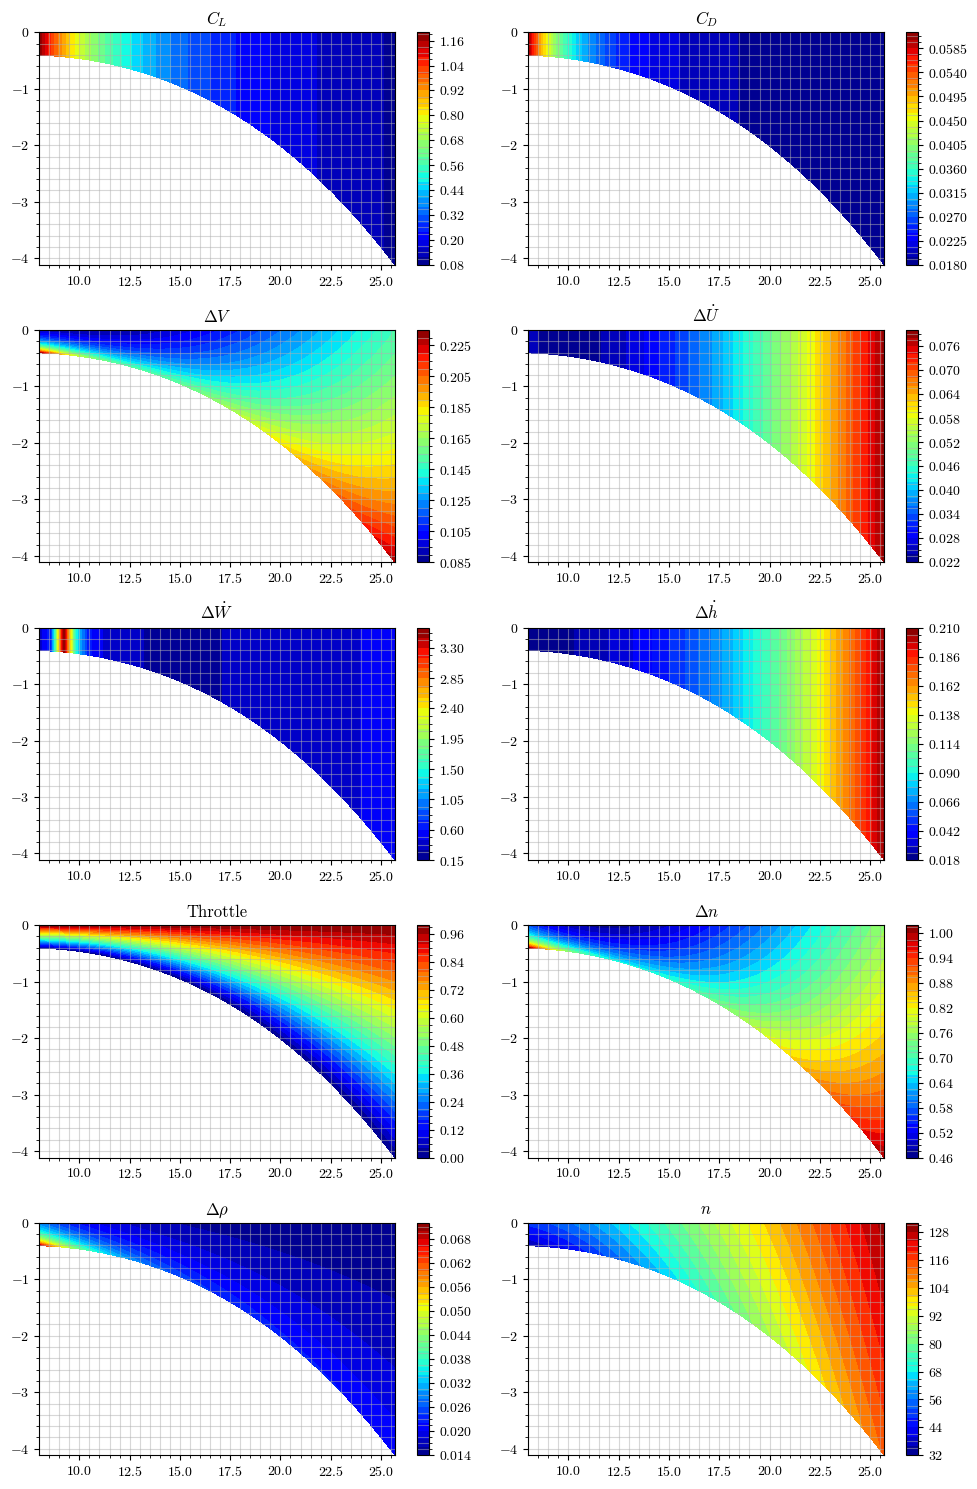

In [35]:
fig, axs = plt.subplots(5, 2, layout='tight')
print(axs[0])
fig.set_size_inches(10,15)
for i, ax in enumerate(axs.flat):
    pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=30)
    print(labels[i])
    ax.set_title(labels[i])
    fig.colorbar(pcm, ax=ax)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_37380/2766226519.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax1)


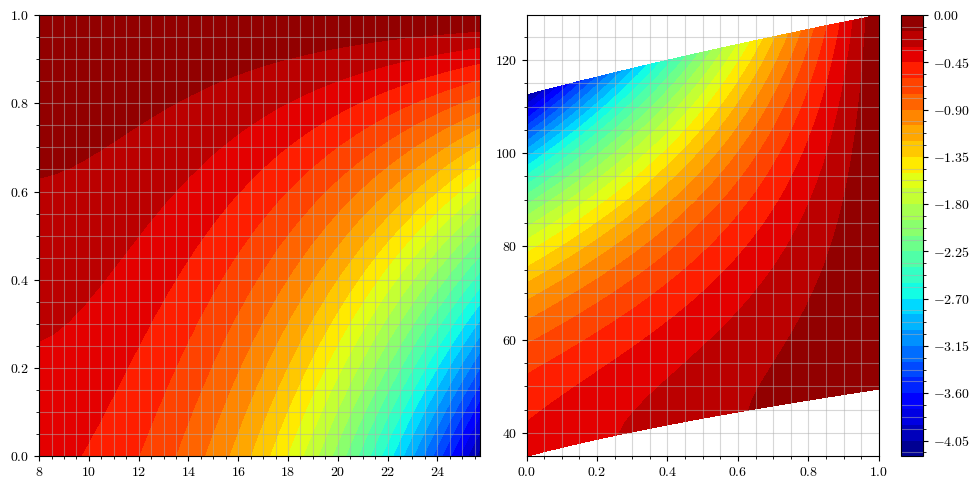

In [36]:
fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.contourf(V_INF_op, THROTTLE, h_dot_op, cmap="jet", levels=30)
pcm = ax1.contourf(THROTTLE, N_op, h_dot_op, cmap="jet", levels=30)
fig.colorbar(pcm, ax=ax1)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21954/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


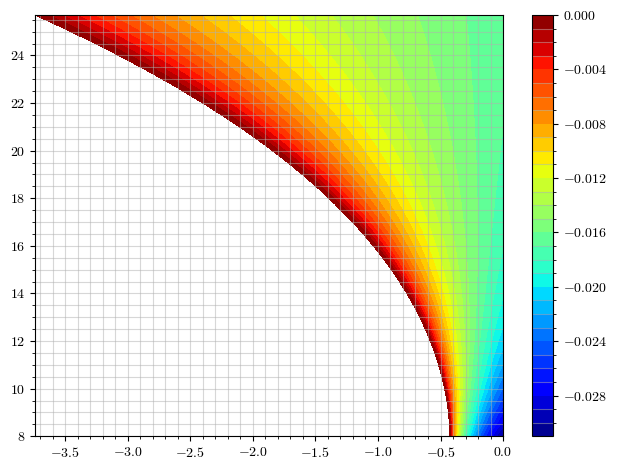

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, drho_vec, cmap="jet", levels=30)
plt.colorbar()
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21954/2788661297.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


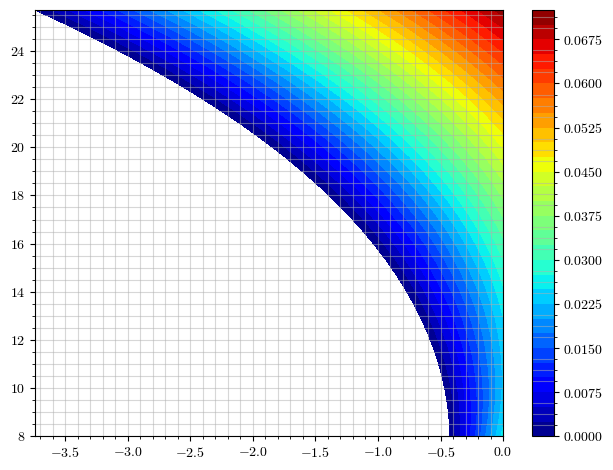

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, dU_dot_vec, cmap="jet", levels=30)
plt.colorbar()
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21954/738689557.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


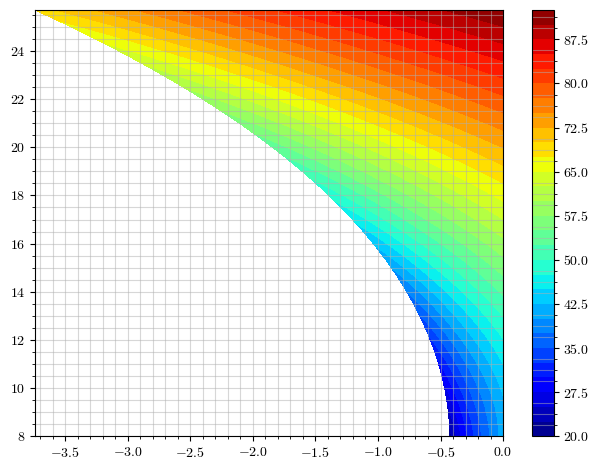

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, N_op, cmap="jet", levels=30)
plt.colorbar()
plt.show()